## importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import os
import requests
from io import BytesIO
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAvgPool2D
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from random import shuffle
import math
import shutil
import glob
from IPython.display import HTML, display
import cv2
import keras
from keras.models import load_model


Using TensorFlow backend.


## Importing data set

In [5]:
df = pd.read_csv("./data_source.csv")
print("Total records = ", len(df))
df.head()

Total records =  64084


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


In [9]:
# select only the columns that we are interested in
df = df[["_unit_id", "please_select_the_gender_of_the_person_in_the_picture",
    "please_select_the_gender_of_the_person_in_the_picture:confidence", "image_url"]]
df.head()

,_unit_id,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url
0,1023132475,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...
1,1023132476,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...
2,1023132477,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...
3,1023132478,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...
4,1023132479,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...


In [11]:
# rename the columns
df.columns = ["id", "gender", "confidence", "url"]
df.head()

,id,gender,confidence,url
0,1023132475,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...
1,1023132476,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...
2,1023132477,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...
3,1023132478,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...
4,1023132479,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...


In [12]:
# only select the rows that has confidence of 1.0
df = df[df["confidence"] == 1]
 
print("Total records = ", len(df))

Total records =  64075


## counting genders

In [6]:
df.groupby("gender").count()

,id,confidence,url
gender,,,
female,7364,7364,7364
male,47592,47592,47592
unsure,9119,9119,9119


## helper function to display image urls

In [13]:


def display_images(df, category_name="male", count=12):
    filtered_df = df[df["gender"] == category_name]
    p = np.random.permutation(len(filtered_df))
    p = p[:count]
    img_style = "width:180px; margin:0px; float:left;border:1px solid black;"
    images_list = "".join(["<img src={}>".format(u) for u in filtered_df.iloc[p].url])
    
    display(HTML(images_list))


In [14]:
display_images(df, category_name="female", count=15)

In [15]:
display_images(df, category_name="male", count=15)

### Now let’s create the dataframe that contains equal number of samples from male and female categories only.


In [16]:

df_male = df[df["gender"] == "male"]
df_female = df[df["gender"] == "female"]
 
# to make both categories have equal number of samples
# we'll take the counts of the category that has lowest
# number of samples
min_samples = min(len(df_male), len(df_female))
 
# for indexing randomly
p = np.random.permutation(min_samples)
 
df_male = df_male.iloc[p]
df_female = df_female.iloc[p]
 
print("Total male samples = ", len(df_male))
print("Total female samples = ", len(df_female))
 
df = pd.concat([df_male, df_female])

Total male samples =  7364
Total female samples =  7364


### download the images using the urls provided

In [ ]:

def download_images(df, data_dir="./data"):
  
    genders = df["gender"].unique()
    for g in genders:
        g_dir = "{}/{}".format(data_dir, g)
        if not os.path.exists(g_dir):
            os.makedirs(g_dir)
           
    for index, row in tqdm.tqdm_notebook(df.iterrows()):
       
        filepath = "{}/{}/{}.jpg".format(data_dir, row["gender"], row["id"])
#         print(filepath)
        
        if os.path.exists(filepath):
            continue
#         qq= open(filepath,"w+")
#         for i in range(10):
#              qq.write("This is line %d\r\n" % (i+1))
        try:
            resp = requests.get(row["url"])
            
            with open(filepath,'wb') as f:
                f.write(resp.content)
        except:
            print("Error while downloading %s" % row["url"])
            
DATA_DIR = "./data"
download_images(df, data_dir=DATA_DIR)
 

### create train/test folder for each gender


In [11]:

DATA_DIR = "./data"
TRAIN_DIR = DATA_DIR + "/train"
TEST_DIR = DATA_DIR + "/test"
 
for d in [TRAIN_DIR, TEST_DIR]:
    for g in df["gender"].unique():
        final_dir = "{}/{}".format(d, g)
        if not os.path.exists(final_dir):
            os.makedirs(final_dir)

In [ ]:

 
split_ratio = 0.7 # we'll reserve 70% of the images for training set
 
def validate_and_move(files, target_dir):
    for f in tqdm.tqdm_notebook(files):
        # try to open the file to make sure that this is not corrupted
        try:
            im = Image.open(f)
            shutil.copy(f, target_dir)
        except:
            pass
#             os.remove(f)
 
for gender in df["gender"].unique():
    gender_dir = "{}/{}".format(DATA_DIR, gender)
    pattern = "{}/*.jpg".format(gender_dir)
    all_files = glob.glob(pattern)
    shuffle(all_files)
   
    train_up_to = math.ceil(len(all_files) * split_ratio)
    train_files = all_files[:train_up_to]
    test_files = all_files[train_up_to:]
   
   
    validate_and_move(train_files, TRAIN_DIR + "/" + gender)
    validate_and_move(test_files, TEST_DIR + "/" + gender)
    

## build a simple convolutional neural network in Keras to classify whether a person in an image is male or female.

In [19]:

# %matplotlib inline
 
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
IM_WIDTH = 198
IM_HEIGHT = 198
 
def plot_images(images, labels):
    n_cols = min(5, len(images))
    n_rows = len(images) // n_cols
    fig = plt.figure(figsize=(8, 8))
 
    for i in range(n_rows * n_cols):
        sp = fig.add_subplot(n_rows, n_cols, i+1)
        plt.axis("off")
        plt.imshow(images[i], cmap=plt.cm.gray)
        sp.set_title(labels[i])
    plt.show()

In [13]:

img_input = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = Conv2D(filters=32, kernel_size=3)(img_input)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)
 
_ = Conv2D(filters=64, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)
 
_ = Conv2D(filters=64, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)
 
_ = Conv2D(filters=128, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)
 
_ = Conv2D(filters=128, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = GlobalAvgPool2D()(_)
 
_ = Dense(128)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
 
_ = Dense(1)(_)
_ = Activation("sigmoid")(_)
 
model = Model(inputs=img_input, outputs=_)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 196, 196, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 196, 196, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
acti

### Normalise the data

In [20]:

train_data_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              horizontal_flip=True
                             )
 
test_data_gen = ImageDataGenerator(rescale=1./255)
 
batch_size = 32
train_gen = train_data_gen.flow_from_directory(TRAIN_DIR,
                                               target_size=(IM_WIDTH, IM_HEIGHT),
                                               class_mode="binary",
                                               batch_size=batch_size)
test_gen = test_data_gen.flow_from_directory(TEST_DIR,
                                            target_size=(IM_WIDTH, IM_HEIGHT),
                                            class_mode="binary",
                                            batch_size=batch_size)
 

Found 10156 images belonging to 2 classes.
Found 4340 images belonging to 2 classes.


#### train the model


In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch=len(train_gen.filenames)//batch_size, epochs=16)


In [25]:
model.evaluate_generator(test_gen, steps=len(test_gen.filenames)//batch_size)


[0.19247996472963716, 0.9213091921452139]

### predict for one batch of test images

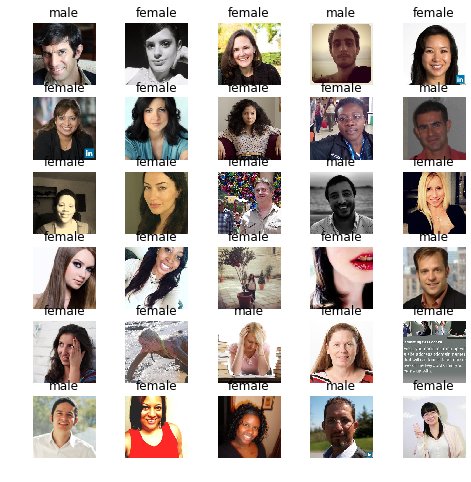

In [23]:
imgs, y_true = next(test_gen)
predictions = model.predict(imgs, batch_size=imgs.shape[0])
 
# how do I know if male is 0 or 1? ImageDataGenerator has a property class_indices
# try printing test_gen.class_indices
# since sigmoid produces value between 0 and 1, we create a threshold and say
# any value > 0.5 is a male otherwise it is female
predictions_str = np.where(predictions.flatten() > 0.5, "male", "female")
plot_images(imgs, predictions_str)

### Save model to the memory

In [ ]:
model.save("train_model.h5")
del model

### Load the model from hard disk

In [22]:

model = load_model("train_model.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Real time recognition

In [26]:

# model = keras.models.load_model('train_model')
 
# capture video from webcam
cap = cv2.VideoCapture(0)
# initialize face detection
cascPath = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)
 
while(True):
    # read a frame. frame is in BGR( Blue, Green, Red) format
    ret, frame = cap.read()
 
    # convert the image to grayscale for performing face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        image=gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
 
    # create a rgb frame since our model expects its input image
    # to be in RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
   
 
    cropped_faces = []
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        # increase the width, height of face region by some pixels.
        # we want a bit more pixels rather than just the face
        extra_pad = 40
        x = max(1, x - extra_pad)
        y = max(1, y - extra_pad)
        width = min(frame.shape[1], x + w + extra_pad*2)
        height = min(frame.shape[0], y + h + extra_pad*2)
        cv2.rectangle(rgb_frame, (x, y), (width, height), (0, 255, 255), 2)
 
        # crop the face
        cropped = rgb_frame[y: height, x: width].astype("float32")
        cropped = cv2.resize(cropped, (198, 198))
       
        # need to rescale the values from 0 to 1
        cropped = cropped /255.0
        cropped = np.clip(cropped, 0, 1)
       
        cropped_faces.append(cropped)
 
 
    # predict the faces
    cv2.putText(rgb_frame, "Total faces = {}".format(len(faces)), (10, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (30, 255, 200), 2)
    if len(faces) > 0 and 1 == 1:
        predictions = model.predict(np.array(cropped_faces))
        predictions = np.where(predictions.flatten() < 0.5, "female", "male")
        for i, prediction in enumerate(predictions):
#             print(prediction)
            text = prediction
 
            x, y, _, _ = faces[i]
            cv2.putText(rgb_frame, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
   
    # convert our RGB frame back to BGR format before displaying
    cv2.imshow('frame', cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
model.summary()